# Lab 6: Fully Connected Network

<p align="justify"> In this Lab we are going to classify a new set of images in 10 classes (multi-class  classification) using a fully connected network (FCN).<p>

<p align="justify"> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. There are 10 different classes of digits, from 0 to 9
. All the images have a size of 28x28 pixels. The MNIST database contains 70,000 images, that we have divided in 60% training, 20% validation and 20% testing. The dataset has the following structure: </p>


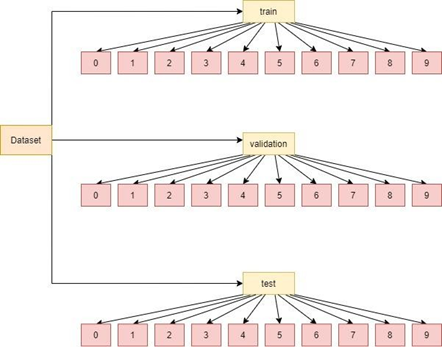



To classify these handwritten digits, we are going to follow the next steps:



*   Create a Fully Connected Neural Network (FCN) and train it to be able to classify these images.
*   Validate our model performance using validation metrics




<a name="1"></a>
## Environment set up

<p align="justify"> We are going to use Python as our programming language, Google Collaboratory (Colab) as our work environment and Pytorch as our machine learning platform.</p>

<p align="justify"> PyTorch is an open-source machine learning library and deep learning framework developed by Facebook's AI Research lab (FAIR). It is commonly employed for several deep learning and artificial intelligence applications, including computer vision, reinforcement learning, natural language processing, and neural network training. Since we are going to build our model in Pytorch, you can use Pytorch tutorials from https://pytorch.org/tutorials/ for extra help.</p>


<a name="1"></a>
## **1. 	Importing necessary libraries and dataset**
In Python, like any other programming language, we need to import the tools that we want to use for our project:

*	NumPy library for simple Python computing commands
* Torch and torch.nn as nn
*	Torchvision and torchvision.transforms as transforms
*	Scikit learn (sklearn) and itertools library for plotting confusion matrix
*	Pyplot from Matplotlib for plotting our data
*	train_test_split from Scikit learn for splitting the train data







In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

#### Setting the Device:
When working with Pytorch, we must check if a CUDA-compatible GPU is available, and if so, we set the device to 'cuda'; otherwise, we use the CPU ('cpu'):

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Define Hyperparameters:
Before we start, we should specify hyperparameters for our neural network, including input size, hidden layer size, the number of classes, the size of the validation set, the number of training epochs, batch size, and learning rate:

In [3]:
input_size = 784
hidden_size = 50
num_classes = 10
validation_size = 0.2
num_epochs = 5
batch_size = 100


####  Define Data Transformations:
<p align="justify">Before we train our model, we need to pre-process the data. Data pre-processing is a data mining technique to turn the raw data gathered from diverse sources into cleaner information that is more suitable for work. In other words, it’s a preliminary step that takes all the available information to organize it, sort it, and merge it. Thanks to the **Pytorch Transform** library we can use one single function to do all of the pre-processing operations on the datasets. The transform variable defines a series of transformations to be applied to the input data. </p>

<p align="justify">PyTorch transforms function can be used for various operations on images, including data augmentation. During data loading, you may easily apply various image processing and augmentation techniques to your dataset by using PyTorch's transformations module. Data augmentation is a typical deep learning technique that involves transforming the input images to artificially expand the size of the training dataset. This may enhance the resilience and generalization of the model.</p>

<p align="justify">The first step of our pre-processing is converting image matrices to **tensors**. Tensors are multi-dimensional arrays in PyTorch that resemble NumPy arrays but have extra features specifically made to speed up deep learning operations. The core data structure in PyTorch is called a tensor, and it is used to represent and work with data, such as input data, model parameters, and gradients during training. The automatic differentiation system of PyTorch, which is essential for training neural networks, is built around tensors.</p>


<p align="justify">The seond step of our pre-processing is scaling the image data. If you print an image without plotting it, you will see that each image is stored as a matrix of numbers from 0 to 255. To normalize our data, we need to rescale these images (matrices) between range of 0 to 1 using **Normalize** function.</p>



Here, we convert the data to PyTorch tensors and normalize it:

In [4]:
transform = transforms.Compose([
     transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
 ])

#### Load the MNIST Dataset:
Next we load the MNIST dataset, both the training and test sets from torchvision datasets. The root parameter specifies the directory to save the dataset, and the transform parameter applies the previously defined transformations to the data:

In [5]:
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transform,
                                          download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 164554616.73it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15012479.10it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 58296522.86it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15413049.17it/s]


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



####  Split the Training Data into Training and Validation Sets:
<p align="justify"> Here we use the train_test_split function from scikit-learn to split the original training dataset into a new training set (train_dataset) and a validation set (val_dataset) based on the specified validation_size. We will reserve 10% of the data as a validation set:

In [6]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=validation_size, random_state=42)

In [7]:
# Data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# The test_loader remains unchanged for the test set
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


<a name="1"></a>
## **2. Visualization**

Now that we have loaded our datasets, we want to see some samples of each set:

train data samples:


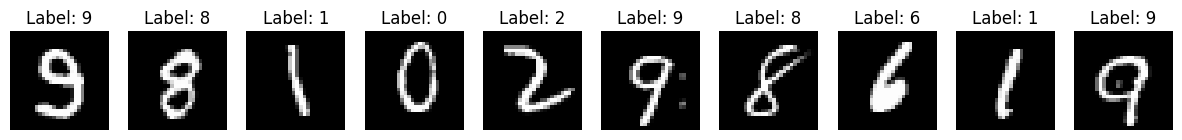

test data samples:


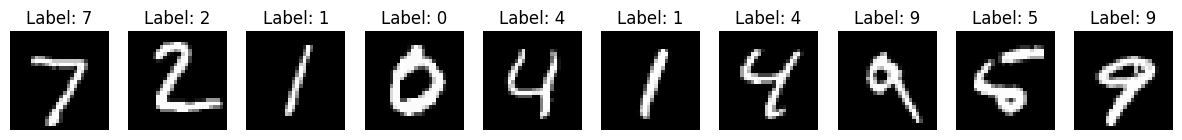

In [8]:
# display samples from the training set
def show_samples(train_loader, num_samples=10):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.show()

# Visualize ten samples from the training set
print("train data samples:")
show_samples(train_loader, num_samples=10)
print("test data samples:")
show_samples(test_loader, num_samples=10)


<a name="1"></a>
## **3**. **Build the mode**l
For fully connected neural networks, there are three essential questions that define the network’s architecture:
* How many layers does the network have?
* How many nodes (neurons) are there in each of those layers?
*	What activation function is used at each of those layers?

<p align="justify">There are other factors that can contribute to the performance of a neural network. These include which loss function is used, which optimization algorithm is used, how many training epochs to run before stopping, and the batch size within each epoch.</p>
<p align="justify">Since we are building a fully connected neural network, the size of our input data must be a vector. Instead of several 28x28 images, we need to have several vectors that are all length 784 (28*28=784). For the moment, we will start defining only a single hidden layer.
Its size is a design decision and we can empirically choosen. Finally, the output of the last layer must be the same as number of classes we want to classify: 10. </p>
<p align="justify"></p>


In [9]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = FCNet(input_size, hidden_size, num_classes).to(device)


<a name="1"></a>
## **4. Optimizer and Loss function**

The optimizer and the loss function are essential components for training a neural network (NN).

<p align="justify">In order to reduce the model's error as indicated by the loss function, the optimizer must modify the model's parameters, i.e. weights and biases. The difference between the target values in the training data and the model's predictions is measured by the loss function. In order to reduce this loss during training, the optimizer iteratively modifies the model's parameters, thus directing the model toward improved performance. The neural network is able to learn and adapt to the underlying patterns in the data through the optimizer's minor tweaks to the model during this dynamic process, which eventually improves the neural network's accuracy and predictive power. The choice of optimizer and loss function is critical in determining how effectively and efficiently the neural network learns from the data and converges to a solution that accurately represents the desired mapping between inputs and outputs.</p>

In [10]:
# Hyper-parameters
learning_rate = 0.001
# optimizer
criterion = nn.CrossEntropyLoss()
#Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

<a name="1"></a>
## **5. Build the train function**
<p align="justify">In this step we want to build separate train  and validation functions for our model. Building separate training and validation functions enables us to train and evaluate models effectively. The training function is responsible for adjusting the model's parameters to minimize the training loss, while the validation function assesses how well the model generalizes to unseen data. By keeping these processes distinct, we prevent data leakage, enable cross-validation, and ensure the reliability of our deep learning models as they learn, adapt, and perform well on unseen data:</p>





In [11]:
def Train(model,train_loader,optimizer):
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = (100 * correct / total)

    return loss.item(), accuracy


<a name="1"></a>
## **6. Build the validation function**

In [12]:
def Validate(model,val_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in val_loader:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = (100 * correct / total)
  return loss.item(),accuracy

<a name="1"></a>
## **7. Run training and validation**
<p align="justify"> Next we run our model and calculate the accuracy and loss for train and validation in each epoch:

In [13]:
# Hyper-parameters
num_epochs = 10
T_loss= []
v_loss =[]
T_acc = []
v_acc = []
# run
for epoch in range(num_epochs):

  train_loss, train_acc = Train(model, train_loader, optimizer)
  val_loss, val_acc = Validate(model, val_loader)

  print ('Epoch [{}/{}], train Loss: {:.4f}, train acc: {:.4f}, val Loss: {:.4f} , val acc: {:.4f}'
            .format(epoch+1, num_epochs, train_loss,train_acc, val_loss,val_acc))
  T_loss.append(train_loss)
  v_loss.append(val_loss)
  T_acc.append(train_acc)
  v_acc.append(val_acc)


Epoch [1/10], train Loss: 1.9954, train acc: 33.4479, val Loss: 1.9587 , val acc: 53.4750
Epoch [2/10], train Loss: 1.6683, train acc: 62.1750, val Loss: 1.5838 , val acc: 67.9667
Epoch [3/10], train Loss: 1.2706, train acc: 72.0563, val Loss: 1.2409 , val acc: 75.6833
Epoch [4/10], train Loss: 1.1105, train acc: 77.3063, val Loss: 0.9781 , val acc: 79.1667
Epoch [5/10], train Loss: 0.9077, train acc: 80.2479, val Loss: 0.7962 , val acc: 81.2667
Epoch [6/10], train Loss: 0.8308, train acc: 82.2125, val Loss: 0.6746 , val acc: 82.9417
Epoch [7/10], train Loss: 0.6262, train acc: 83.6354, val Loss: 0.5851 , val acc: 84.0917
Epoch [8/10], train Loss: 0.5536, train acc: 84.5521, val Loss: 0.5197 , val acc: 84.9083
Epoch [9/10], train Loss: 0.5367, train acc: 85.3063, val Loss: 0.4695 , val acc: 85.6083
Epoch [10/10], train Loss: 0.5283, train acc: 85.9229, val Loss: 0.4325 , val acc: 86.2167


<a name="8"></a>
## **8. Analysing model performance**
<p align="justify"> After the training is finished you need to analyse your model performance.  You should see a message for each of the 10 epochs printing the loss and accuracy for the train dataset, followed by the final evaluation of the trained model (at the end of every epoch) on the validation dataset (val_acc and val_loss).Note that val_acc refers to a set of samples that was not shown to the network during training and hence refers to how much your model works in general for cases outside the training set.</p>

<p align="justify"> It is common for validation accuracy to be lower than accuracy (for your training data). But ideally, you should strive to keep those values at the same level.</p>

<p align="justify"> Ideally, we would like the loss to go to zero and accuracy to go to 1.0 (e.g. 100%). This is not possible for any but the most trivial machine learning problems. Instead, you will always have some error in your model.  Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.</p>

<p align="justify"> Later on, you may change the hyperparameters of your model: architecture of the model (number of layers, number of neurons per layer), number of epochs, learning rate, momentum, optimizer, etc. The goal is to choose a model configuration that achieves the lowest loss and highest accuracy possible for a given dataset.</p>

<p align="justify"> For the moment, let’s start the analysis by plotting your loss and accuracy. Using these plots, you can visually see your model performance through all epochs. If, during training, your validation loss starts increasing while your training loss is still decreasing, this is an indicator of overfitting. </p>


####  Plots


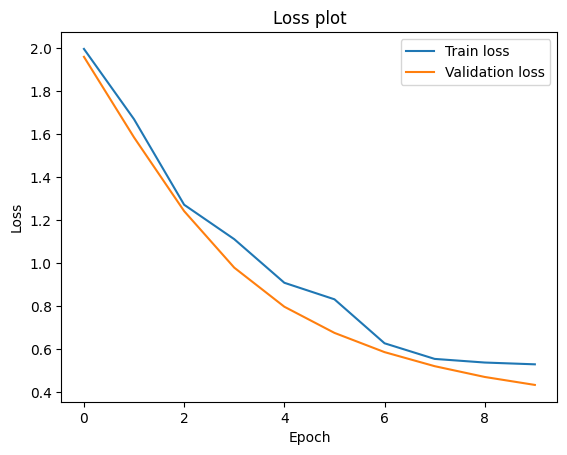

In [14]:
epochs = [i for i in range (num_epochs)]

plt.plot(epochs, T_loss, label='Train loss')
plt.plot(epochs, v_loss, label='Validation loss')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()


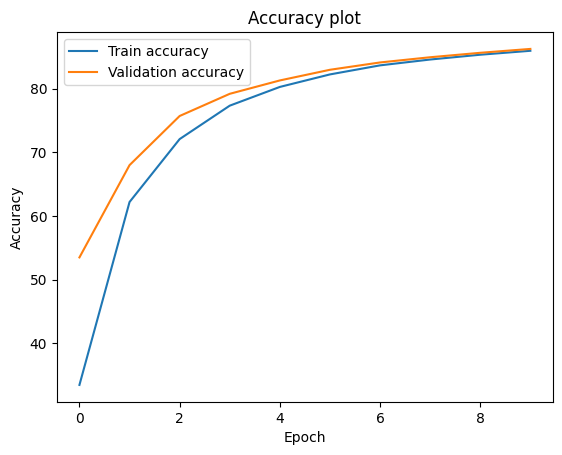

In [15]:

plt.plot(epochs, T_acc, label='Train accuracy')
plt.plot(epochs, v_acc, label='Validation accuracy')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()


<a name="1"></a>
## **9. Testing the model**
At the very end you should test your NN against some test set that is different from you training set and validation set and thus has never been touched during the training process:

In [16]:
predict = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict.extend(predicted.tolist())



    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    print(len(predict))

Accuracy of the network on the 10000 test images: 86.7 %
10000


<a name="1"></a>
## **10. Confusion matrix**
Finally, with a confusion matrix you can check where your model misclassification classes are:

Confusion matrix, without normalization
[[ 940    0    1    2    1   17   14    2    3    0]
 [   0 1091    6    5    0    5    4    0   24    0]
 [  14   29  835   29   26    1   26   24   43    5]
 [   4    8   26  866    0   37    7   24   30    8]
 [   1   10    1    0  876    2   21    3    7   61]
 [  15   18    3   67   26  688   25   13   22   15]
 [  18    6   16    0   20   26  866    2    4    0]
 [   4   34   27    0   14    1    0  904    8   36]
 [  11   19   19   44   12   41   17   10  769   32]
 [  15   11    6    9   65    9    4   46    9  835]]


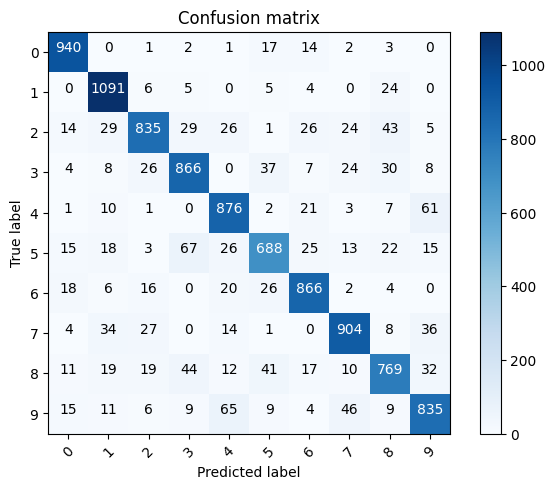

In [17]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

x_test = []
y_test = []
for data, target in test_loader:
  x_test.extend(data)
  y_test.extend(target)

cm = confusion_matrix(y_test, predict)
plot_confusion_matrix(cm,list(range(10)))

<a name="1"></a>
## **11. Save model checkpoints**
<p align="justify"> Model checkpoint saving is a critical task in deep learning, involving the periodic saving of a model's parameters during training. This process allows you to resume interrupted training, implementing early stopping, and selecting the best-performing model. Checkpoints allow the training to resume from the last saved state, preventing loss of progress, and supporting hyperparameter tuning and experimentation. They enable efficient model selection and are crucial for deploying trained models for inference, ensuring that the trained model can be used reliably without the need to retrain it from scratch, ultimately improving the efficiency and robustness of deep learning model development.</p>

In [18]:
torch.save(model.state_dict(), 'model.ckpt')

<a name="1"></a>
## **12. Build your own model**
<p align="justify"> In the cell code below, build a new model, trying to improve the performance obtained by the default architecture. You can increase the number of neurons of the hidden layer, increase the number of hidden layers, or make any changes (loss function, learning rate, optimizer, number of epochs etc.) in the hyperparameters used above. You can also use the Transform function to adopt data augmentation to your dataset. </p>

***Setting Hyperparameters***

In [19]:
# Implement your solution here
#Hyper parameters
input_size = 784
hidden_size = 90
num_classes = 10
validation_size = 0.2
num_epochs = 20
batch_size = 80

***Define the model***

In [20]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        #self.fc3 = nn.Linear(hidden_size, hidden_size)  # Third hidden layer
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)  # Adding ReLU activation after the second hidden layer
        out = self.fc3(out)
        #out = self.relu(out)  # Adding ReLU activation after the third hidden layer
        #out = self.fc4(out)

        return out

model = FCNet(input_size, hidden_size, num_classes).to(device)


***Optimizer and loss function***

In [21]:
# Hyper-parameters
learning_rate = 0.001
# optimizer
criterion = nn.CrossEntropyLoss()
#Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


***Build the train function***

In [22]:
def Train(model,train_loader,optimizer):
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = (100 * correct / total)

    return loss.item(), accuracy


***Build the validation function***

In [23]:
def Validate(model,val_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in val_loader:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = (100 * correct / total)
  return loss.item(),accuracy

***Run the model***

In [24]:
# Hyper-parameters
T_loss= []
v_loss =[]
T_acc = []
v_acc = []
# run
for epoch in range(num_epochs):

  train_loss, train_acc = Train(model, train_loader, optimizer)
  val_loss, val_acc = Validate(model, val_loader)

  print ('Epoch [{}/{}], train Loss: {:.4f}, train acc: {:.4f}, val Loss: {:.4f} , val acc: {:.4f}'
            .format(epoch+1, num_epochs, train_loss,train_acc, val_loss,val_acc))
  T_loss.append(train_loss)
  v_loss.append(val_loss)
  T_acc.append(train_acc)
  v_acc.append(val_acc)


Epoch [1/20], train Loss: 2.2322, train acc: 20.1208, val Loss: 2.2295 , val acc: 28.3417
Epoch [2/20], train Loss: 2.1267, train acc: 37.1292, val Loss: 2.1273 , val acc: 43.3167
Epoch [3/20], train Loss: 2.0089, train acc: 45.8917, val Loss: 1.9693 , val acc: 48.5250
Epoch [4/20], train Loss: 1.7540, train acc: 50.9646, val Loss: 1.7439 , val acc: 54.4250
Epoch [5/20], train Loss: 1.6064, train acc: 58.7521, val Loss: 1.4759 , val acc: 62.2000
Epoch [6/20], train Loss: 1.2794, train acc: 67.0375, val Loss: 1.2148 , val acc: 71.2667
Epoch [7/20], train Loss: 1.0791, train acc: 73.4646, val Loss: 0.9987 , val acc: 76.2083
Epoch [8/20], train Loss: 0.9276, train acc: 76.7438, val Loss: 0.8366 , val acc: 78.2333
Epoch [9/20], train Loss: 0.7846, train acc: 79.0833, val Loss: 0.7111 , val acc: 79.7667
Epoch [10/20], train Loss: 0.7657, train acc: 80.7979, val Loss: 0.6164 , val acc: 81.4583
Epoch [11/20], train Loss: 0.7793, train acc: 82.2458, val Loss: 0.5424 , val acc: 82.8333
Epoch [1

***Analysing Model Performance***

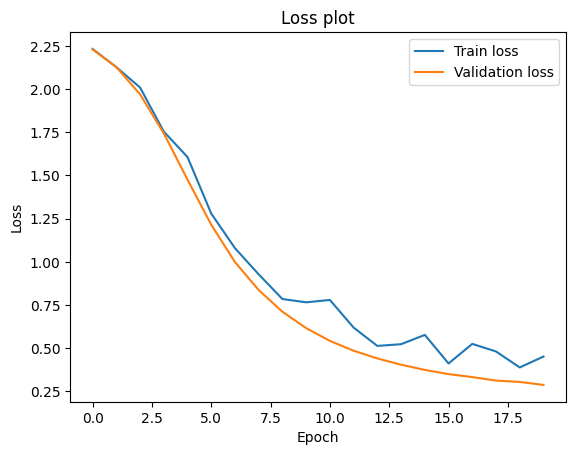

In [25]:
#Plot Loss

epochs = [i for i in range (num_epochs)]

plt.plot(epochs, T_loss, label='Train loss')
plt.plot(epochs, v_loss, label='Validation loss')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()


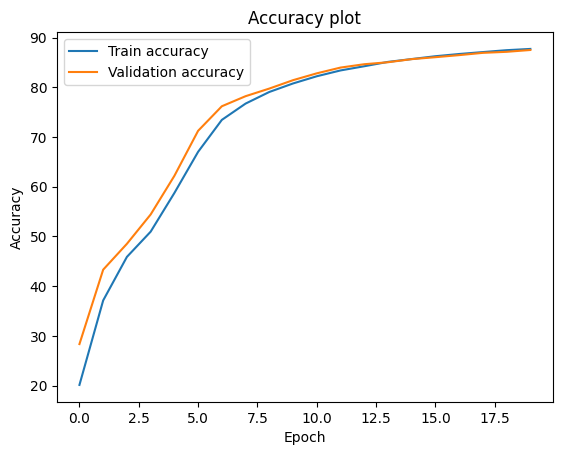

In [26]:
# Plot Accuracy

plt.plot(epochs, T_acc, label='Train accuracy')
plt.plot(epochs, v_acc, label='Validation accuracy')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()


***Model Testing***

In [27]:
predict = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict.extend(predicted.tolist())



    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    print(len(predict))

Accuracy of the network on the 10000 test images: 88.24 %
10000


***Confusion Matrix***

Confusion matrix, without normalization
[[ 947    0    3    1    0   16   11    1    1    0]
 [   0 1096    4    5    1    2    3    1   23    0]
 [  13   18  876   21   29    4   24   12   33    2]
 [   4    3   30  877    0   43    2   22   23    6]
 [   2    6    7    0  882    2   15    1    6   61]
 [  18    7   10   56   14  696   31   14   35   11]
 [  20    3   12    1   24   18  877    0    3    0]
 [   6   19   30    5    4    0    0  908    4   52]
 [   7    8   18   32   12   41   17    8  812   19]
 [  13    6    4    9   65   10    1   38   10  853]]


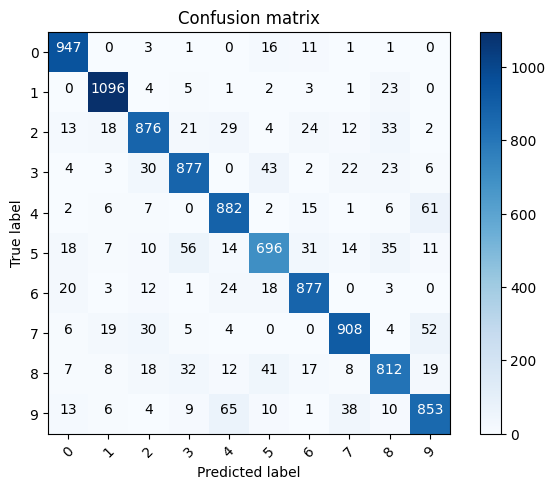

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

x_test = []
y_test = []
for data, target in test_loader:
  x_test.extend(data)
  y_test.extend(target)

cm = confusion_matrix(y_test, predict)
plot_confusion_matrix(cm,list(range(10)))

In [29]:
torch.save(model.state_dict(), 'model.ckpt')